In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers 
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import os
seed_value = 1
os.environ['PYTHONHASHSEED']=str(seed_value)
def reset_random_seeds():
   tf.random.set_seed(seed_value)
   np.random.seed(seed_value)
   random.seed(seed_value)
reset_random_seeds()

In [2]:
!pip3 install transformers

     |████████████████████████████████| 4.0 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 29.5 MB/s 
     |████████████████████████████████| 895 kB 13.0 MB/s 
     |████████████████████████████████| 6.5 MB 33.8 MB/s 
     |████████████████████████████████| 77 kB 5.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
train_data = pd.read_csv("train.csv")
train_data.head()


,Text_ID,Product_Description,Product_Type,Sentiment
0,3057,The Web DesignerÛªs Guide to iOS (and Android...,9,2
1,6254,RT @mention Line for iPad 2 is longer today th...,9,2
2,8212,Crazy that Apple is opening a temporary store ...,9,2
3,4422,The lesson from Google One Pass: In this digit...,9,2
4,5526,RT @mention At the panel: &quot;Your mom has a...,9,2


In [4]:
train_data.isnull().sum()

Text_ID                0
Product_Description    0
Product_Type           0
Sentiment              0
dtype: int64

2    3765
3    2089
1     399
0     111
Name: Sentiment, dtype: int64


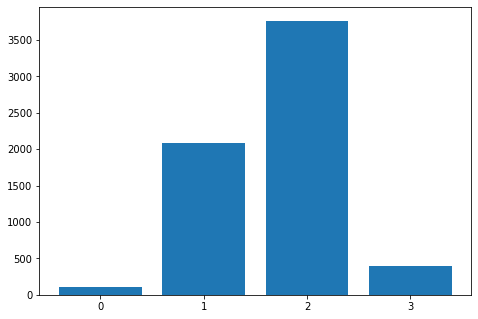

In [5]:
tempdf = train_data["Sentiment"].value_counts()
print(tempdf)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(pd.unique(train_data["Sentiment"]), train_data["Sentiment"].value_counts())
ax.set_xticks(pd.unique(train_data["Sentiment"]))
plt.show()

9    4070
6     665
2     465
7     327
3     300
5     213
8     194
1      59
0      52
4      19
Name: Product_Type, dtype: int64


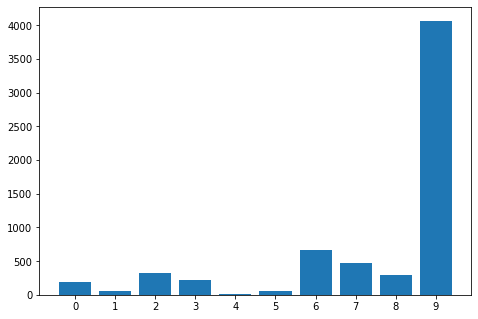

In [6]:

tempdf = train_data["Product_Type"].value_counts()
print(tempdf)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(pd.unique(train_data["Product_Type"]), train_data["Product_Type"].value_counts())
ax.set_xticks(pd.unique(train_data["Product_Type"]))
plt.show()

In [7]:
import re, string, six

def clean_text(s):
    try:
        return re.sub(r'[^A-Za-z0-9,?"\'. ]+', '', s).encode('utf-8').decode('utf-8').lower()
    except:
        return ""

train_data['Product_Description'] = train_data['Product_Description'].apply(lambda x: clean_text(x))
print(train_data['Product_Description'])

0       the web designers guide to ios and android app...
1       rt mention line for ipad 2 is longer today tha...
2       crazy that apple is opening a temporary store ...
3       the lesson from google one pass in this digita...
4       rt mention at the panel quotyour mom has an ip...
                              ...                        
6359    thanks mention for hosting this event sxsw sxs...
6360    sxsw iphone app is awesome, but ipad app crash...
6361    rt mention rt mention download 20 free tracks ...
6362    oh at texas social media awards 'you don't nee...
6363    google launching a quotmajorquot new social ne...
Name: Product_Description, Length: 6364, dtype: object


In [8]:
from numpy.ma.core import shape
from sklearn.model_selection import train_test_split

X = train_data["Product_Description"]
y = train_data["Sentiment"]

X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, random_state=23)
X_test, X_val, y_test, y_val =train_test_split(X_test, y_test, test_size=0.5, random_state=23)
# Shape of Train data
print(shape(X_train))

# Shape of Validation data
print(shape(X_val))

# Shape of Test data
print(shape(X_test))

(5091,)
(637,)
(636,)


In [9]:
#TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=False,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train)
X_val_tfidf = tf_idf.transform(X_val)

In [10]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, cv=kf)

    return auc.mean()

In [11]:
from sklearn.metrics import accuracy_score, roc_curve, auc
def AUCplot(predicted_yval, y_val, prob_predicted_yval):
  preds = prob_predicted_yval[:, 0]
  fpr0, tpr0, threshold0 = roc_curve(y_val, preds, pos_label=1)
  preds = prob_predicted_yval[:, 1]
  fpr1, tpr1, threshold0 = roc_curve(y_val, preds, pos_label=1)
  preds = prob_predicted_yval[:, 2]
  fpr2, tpr2, threshold0 = roc_curve(y_val, preds, pos_label=1)
  preds = prob_predicted_yval[:, 3]
  fpr3, tpr3, threshold0 = roc_curve(y_val, preds, pos_label=1)
  roc_auc0 = auc(fpr0, tpr0)
  print(f'AUC for class 0: {roc_auc0:.4f}')
  roc_auc1 = auc(fpr1, tpr1)
  print(f'AUC for class 1: {roc_auc1:.4f}')
  roc_auc2 = auc(fpr2, tpr2)
  print(f'AUC for class 2: {roc_auc2:.4f}')
  roc_auc3 = auc(fpr3, tpr3)
  print(f'AUC for class 3: {roc_auc3:.4f}')
       
  #   # Get accuracy over the test set
  #y_pred = np.where(preds >= 0.5, 1, 0)
  accuracy = accuracy_score(y_val, predicted_yval)
  print(f'Accuracy: {accuracy*100:.2f}%')
    
  #   # Plot ROC AUC
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr0, tpr0, 'b', label = 'AUC = %0.2f' % roc_auc0)
  plt.plot(fpr1, tpr1, 'g', label = 'AUC = %0.2f' % roc_auc1)
  plt.plot(fpr2, tpr2, 'r', label = 'AUC = %0.2f' % roc_auc2)
  plt.plot(fpr3, tpr3, 'c', label = 'AUC = %0.2f' % roc_auc3)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

2
[9.28888570e-05 1.05379938e-03 7.99324815e-01 1.99528497e-01]
AUC for class 0: 0.6785
AUC for class 1: 0.7481
AUC for class 2: 0.3194
AUC for class 3: 0.6407
Accuracy: 64.21%


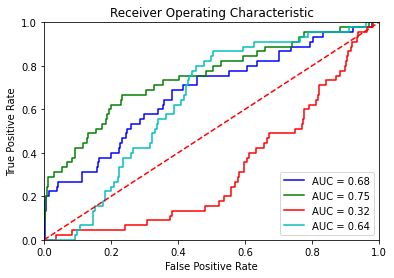

In [12]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB(alpha=0.5)

model.fit(X_train_tfidf, y_train)
prob_predicted_yval = model.predict_proba(X_val_tfidf)
predicted_yval = model.predict(X_val_tfidf)
print(predicted_yval[0])
print(prob_predicted_yval[0])
AUCplot(predicted_yval, y_val, prob_predicted_yval)

In [13]:
model.score(X_val_tfidf, y_val)

0.6420722135007849

In [14]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", do_lower_case = True)


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer

from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

encoded_data_train = tokenizer.batch_encode_plus(
    [text for text in X_train], 
    add_special_tokens=True, 
    return_attention_mask=True,
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    [text for text in X_val], 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor([text for text in y_train])

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor([text for text in y_val])

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
import torch
import torch.nn as nn
from transformers import BertModel

class BertClassifier(nn.Module):
    
    def __init__(self, freeze_bert=False):
        
        super(BertClassifier, self).__init__()
       
        D_in, H, D_out = 768, 50, 4

       
        self.bert = BertModel.from_pretrained('bert-base-uncased')

       
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            
            nn.Linear(H, D_out)
        )

      
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
       
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        last_hidden_state_cls = outputs[0][:, 0, :]

        logits = self.classifier(last_hidden_state_cls)

        return logits

In [18]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

val_dataloader = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [19]:
from transformers import AdamW, get_linear_schedule_with_warmup
def initialize_model(epochs=4):
 
    bert_classifier = BertClassifier(freeze_bert=False)

   
    bert_classifier.to(device)

    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5, 
                      eps=1e-8 
                      )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [20]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
  
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

       
        t0_epoch, t0_batch = time.time(), time.time()

        total_loss, batch_loss, batch_counts = 0, 0, 0

        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            
            model.zero_grad()

            
            logits = model(b_input_ids, b_attn_mask)

           
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

           
            loss.backward()

           
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                
                time_elapsed = time.time() - t0_batch

                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
      
        if evaluation == True:
           
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
   
    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:
       
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        preds = torch.argmax(logits, dim=1).flatten()

        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.992979   |     -      |     -     |   50.35  
   1    |   40    |   0.819316   |     -      |     -     |   48.79  
   1    |   60    |   0.928064   |     -      |     -     |   49.27  
   1    |   80    |   0.780799   |     -      |     -     |   49.32  
   1    |   100   |   0.839730   |     -      |     -     |   49.29  
   1    |   120   |   0.804493   |     -      |     -     |   49.32  
   1    |   140   |   0.750198   |     -      |     -     |   49.46  
   1    |   159   |   0.704724   |     -      |     -     |   44.71  
----------------------------------------------------------------------
   1    |    -    |   0.829339   |  0.759401  |   68.93   |  409.57  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elaps

In [29]:
import torch.nn.functional as F
def bert_predict(model, test_dataloader):
    model.eval()

    all_logits = []
    for batch in test_dataloader:
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    all_logits = torch.cat(all_logits, dim=0)

    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [24]:
def label(probs):
  rs = []
  for p in probs:
    max = -1
    index =-1
    for i in range(len(p)):
      if max < p[i]:
        max = p[i]
        index = i
    rs.append(index)
  return rs

In [25]:
encoded_data_test = tokenizer.batch_encode_plus(
    [text for text in X_test], 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor([text for text in y_test])

dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

dataloader_test = DataLoader(dataset_test, 
                                   sampler=SequentialSampler(dataset_test), 
                                   batch_size=batch_size)





/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [30]:
probs = bert_predict(bert_classifier, dataloader_test)

AUC for class 0: 0.9020
AUC for class 1: 0.9239
AUC for class 2: 0.3011
AUC for class 3: 0.3534
Accuracy: 69.03%


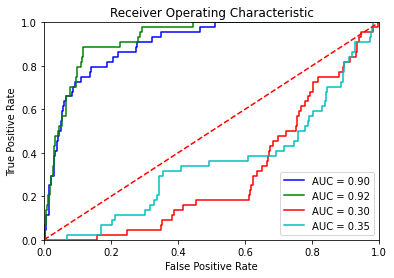

In [33]:
AUCplot(label(probs), y_test, probs)